In [1]:
import os
import random
import sys
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

torch.Size([250, 250, 3])


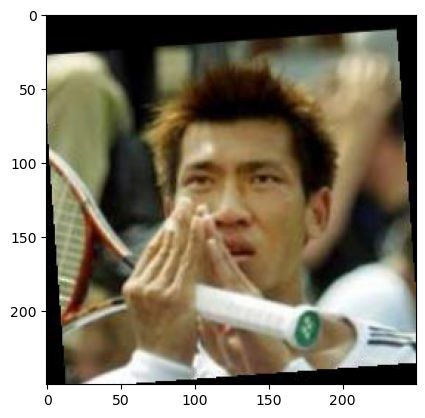

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

In [6]:
IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
LATENT_DIM = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
LOG_INTERVAL = 10

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

path = 'lfw'
dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), LATENT_DIM)
        self.fc_logvar = nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), LATENT_DIM)

        self.decoder_input = nn.Linear(LATENT_DIM, 256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, IMAGE_CHANNELS, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(-1, 256, IMAGE_SIZE // 16, IMAGE_SIZE // 16)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    recon_x = recon_x.clamp(0, 1)
    x = x.clamp(0, 1)
    BCE = F.binary_cross_entropy(recon_x.view(-1, IMAGE_SIZE * IMAGE_SIZE * IMAGE_CHANNELS), x.view(-1, IMAGE_SIZE * IMAGE_SIZE * IMAGE_CHANNELS), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae = VAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train(epoch, vae, optimizer, dataloader, device):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}')

for epoch in range(1, NUM_EPOCHS + 1):
    train(epoch, vae, optimizer, dataloader, device)

Train Epoch: 1 [0/13237 (0%)]	Loss: 33787.261719
Train Epoch: 1 [320/13237 (2%)]	Loss: 33196.761719
Train Epoch: 1 [640/13237 (5%)]	Loss: 31167.652344
Train Epoch: 1 [960/13237 (7%)]	Loss: 31379.318359
Train Epoch: 1 [1280/13237 (10%)]	Loss: 30049.789062
Train Epoch: 1 [1600/13237 (12%)]	Loss: 29745.808594
Train Epoch: 1 [1920/13237 (14%)]	Loss: 28484.259766
Train Epoch: 1 [2240/13237 (17%)]	Loss: 30009.271484
Train Epoch: 1 [2560/13237 (19%)]	Loss: 29037.447266
Train Epoch: 1 [2880/13237 (22%)]	Loss: 27247.744141
Train Epoch: 1 [3200/13237 (24%)]	Loss: 26050.003906
Train Epoch: 1 [3520/13237 (27%)]	Loss: 28344.001953
Train Epoch: 1 [3840/13237 (29%)]	Loss: 26646.824219
Train Epoch: 1 [4160/13237 (31%)]	Loss: 26453.962891
Train Epoch: 1 [4480/13237 (34%)]	Loss: 25985.246094
Train Epoch: 1 [4800/13237 (36%)]	Loss: 26437.130859
Train Epoch: 1 [5120/13237 (39%)]	Loss: 26039.384766
Train Epoch: 1 [5440/13237 (41%)]	Loss: 27562.228516
Train Epoch: 1 [5760/13237 (43%)]	Loss: 24951.085938
Tra

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

IMAGE_CHANNELS = 3

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return F.relu(x + self.block(x))
    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.fc_mu = nn.Linear(256 * 8 * 8, 128)
        self.fc_logvar = nn.Linear(256 * 8 * 8, 128)
        self.decoder_input = nn.Linear(128, 256 * 8 * 8)

    def build_encoder(self):
        layers = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )
        return layers

    def build_decoder(self):
        layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32),
            nn.ConvTranspose2d(32, IMAGE_CHANNELS, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        return layers

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [8]:
import torch
import torch.nn as nn

IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
LATENT_DIM = 128

# VAE Class
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), LATENT_DIM)
        self.fc_logvar = nn.Linear(256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), LATENT_DIM)

        self.decoder_input = nn.Linear(LATENT_DIM, 256 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, IMAGE_CHANNELS, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(-1, 256, IMAGE_SIZE // 16, IMAGE_SIZE // 16)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)

test_image = torch.rand(1, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
test_image = test_image.to(device)

with torch.no_grad():
    mu, logvar = vae.encode(test_image)
    print("Shape of encoder output (mu):", mu.shape)

z = vae.reparameterize(mu, logvar)
with torch.no_grad():
    new_images = vae.decode(z)
    print("Shape of new images from decoder:", new_images.shape)

with torch.no_grad():
    reconstructed_image, _, _ = vae(test_image)
    print("Shape of reconstructed image:", reconstructed_image.shape)


Shape of encoder output (mu): torch.Size([1, 128])
Shape of new images from decoder: torch.Size([1, 3, 128, 128])
Shape of reconstructed image: torch.Size([1, 3, 128, 128])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
LATENT_DIM = 128
LEARNING_RATE = 0.001

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), LATENT_DIM)
        self.fc_logvar = nn.Linear(64 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), LATENT_DIM)

        self.decoder_input = nn.Linear(LATENT_DIM, 64 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, IMAGE_CHANNELS, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(-1, 64, IMAGE_SIZE // 4, IMAGE_SIZE // 4)
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)

total_params = sum(p.numel() for p in vae.parameters())
print(f"Total number of parameters in the model: {total_params}")

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)


Total number of parameters in the model: 25300355


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [10]:
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()  
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()  
        optimizer.step() 
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

Epoch 1, Loss: 26453.0888
Epoch 2, Loss: 24722.0377
Epoch 3, Loss: 24424.6947
Epoch 4, Loss: 24281.5689
Epoch 5, Loss: 24199.3646
Epoch 6, Loss: 24154.5708
Epoch 7, Loss: 24122.6913
Epoch 8, Loss: 24092.6354
Epoch 9, Loss: 24067.1734
Epoch 10, Loss: 24045.1550


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

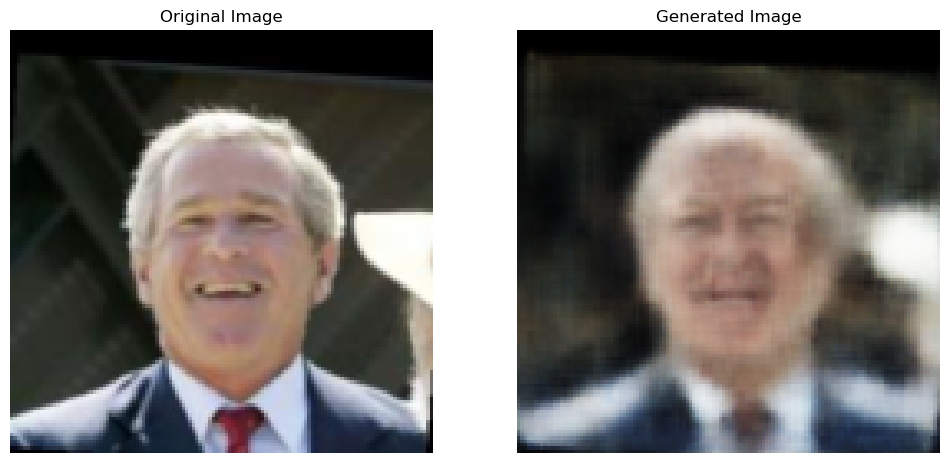

In [41]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

dataiter = iter(dataloader)
images, _ = next(dataiter)

original_image = images[0].unsqueeze(0).to(device)

with torch.no_grad():
    mu, logvar = vae.encode(original_image)
    z = vae.reparameterize(mu, logvar)
    generated_image = vae.decode(z)

original_grid = make_grid(original_image.cpu(), nrow=5)
generated_grid = make_grid(generated_image.cpu(), nrow=5)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_grid.permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_grid.permute(1, 2, 0))
plt.axis('off')

plt.show()
